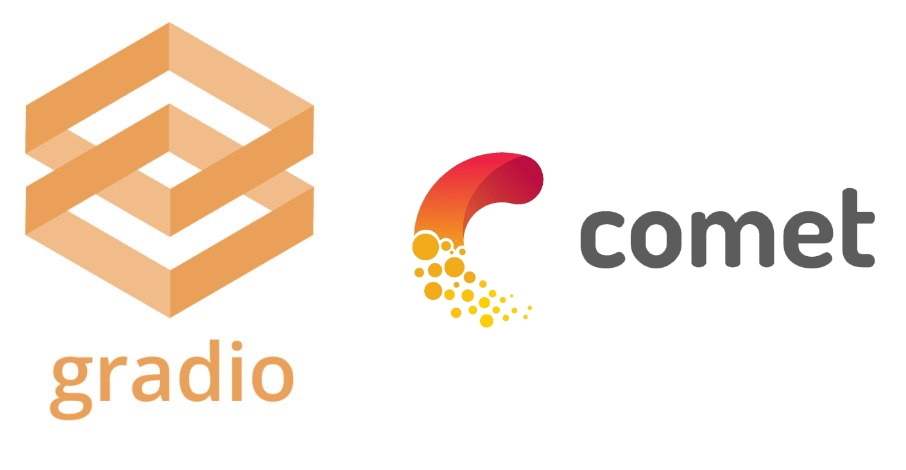

# Introduction

[Gradio](https://www.gradio.app/) allows you to quickly create customizable UI components around your TensorFlow or PyTorch models, or even arbitrary Python functions. Mix and match components to support any combination of inputs and outputs. Our core library is free and open-source!

[Comet](https://www.comet.ml/site/data-scientists/?utm_campaign=gradio-integration&utm_medium=colab) is an MLOps Platform that is designed to help Data Scientists and Teams build better models faster! Comet provides tooling to track, Explain, Manage, and Monitor your models in a single place! It works with Jupyter Notebooks and Scripts and most importantly it's 100% free!

In this notebook, we will go over a few of the User Interfaces you can create for your models with Gradio and how to log them to Comet and view them with the Gradio Panel.          

# Setup

This integration enables you to access and interact with your Gradio Interface from within Comet.

To do so, search for “Gradio” in the Public section of the Comet Panels Gallery. Add it to your project or experiment, and run any of the example snippets below to get started.

**Note: ** Your UI's will expire after 24 hours if you are not using a hosted version of Gradio. Find out more about hosting your UI's [here](https://www.gradio.app/sharing_your_app/)

## Install Dependencies

In [ ]:
%pip install -U comet_ml gradio altair torch torchvision transformers requests Pillow

## Initialize Comet and Gradio

In [ ]:
import comet_ml
import gradio as gr
comet_ml.init(project_name='gradio')

# Interfaces for Image Models

Lets set up a some interfaces to test out Image Classification. 

After running the example, you will see a link to a Comet Experiment with the logged UI. If you head over to the Panels tab in the Experiment, you will a Gradio Panel that you can use to view the UI.  

## Image Classification 

In this example, we will build an interface to interact with an image classification model; `resnet18` 


In [ ]:
from urllib.request import urlretrieve

import requests
import torch
from PIL import Image
from torchvision import transforms

urlretrieve(
    "https://www.discoverboating.com/sites/default/files/inline-images/buying-a-sailboat-checklist.jpg",
    "sailboat.jpg",
)
urlretrieve(
    "https://external-preview.redd.it/lG5mI_9Co1obw2TiY0e-oChlXfEQY3tsRaIjpYjERqs.jpg?auto=webp&s=ea81982f44b83efbb803c8cff8953ee547624f70",
    "bicycle.jpg",
)

experiment = comet_ml.Experiment()
experiment.add_tag("image-classifier")

model = torch.hub.load("pytorch/vision:v0.6.0", "resnet18", pretrained=True).eval()

# Download human-readable labels for ImageNet.
response = requests.get("https://git.io/JJkYN")
labels = response.text.split("\n")


def predict(inp):
    inp = Image.fromarray(inp.astype("uint8"), "RGB")
    inp = transforms.ToTensor()(inp).unsqueeze(0)
    with torch.no_grad():
        prediction = torch.nn.functional.softmax(model(inp)[0], dim=0)
    return {labels[i]: float(prediction[i]) for i in range(1000)}


inputs = gr.Image()
outputs = gr.Label(num_top_classes=3)

io = gr.Interface(
    fn=predict, inputs=inputs, outputs=outputs, examples=["sailboat.jpg", "bicycle.jpg"]
)
io.launch(inline=False, share=True)
io.integrate(comet_ml=experiment)


# Interfaces for NLP Models

Lets build some interfaces to interact with Transformers 

## Text Generation

In this example we will build a UI around GPT2 to generate a story. 

In [ ]:
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel

experiment = comet_ml.Experiment()
experiment.add_tag("text-generation")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)


def generate_text(inp):
    input_ids = tokenizer.encode(inp, return_tensors="tf")
    beam_output = model.generate(
        input_ids,
        max_length=100,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True,
    )
    output = tokenizer.decode(
        beam_output[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return ".".join(output.split(".")[:-1]) + "."

input_text = gr.Textbox(label="Input Prompt")
output_text = gr.Textbox(label="Generated Output")
io = gr.Interface(
    generate_text,
    inputs=[input_text],
    outputs=[output_text],
    examples=[
        [
            "The dectective looked at the room full of suspects and said, "
        ]
    ],
)
io.launch(inline=False, share=True)
io.integrate(comet_ml=experiment)

## Question Answering

Let's build a UI for question answering with DistilBert

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    pipeline,
)

experiment = comet_ml.Experiment()
experiment.add_tag("question-answering")

do_lower_case = True
model_version = "distilbert-base-uncased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(
    model_version, do_lower_case=do_lower_case
)
tokenizer.pad_token = "[PAD]"
model = AutoModelForQuestionAnswering.from_pretrained(
    model_version, output_attentions=True, pad_token_id=tokenizer.eos_token_id
)

qa = pipeline("question-answering", model=model, tokenizer=tokenizer)

def qa_func(context, question):
    prediction = qa(question=question, context=context)
    answer = prediction['answer']

    return answer

io = gr.Interface(
    qa_func,
    inputs=[
        gr.Textbox(lines=7, label="Context"),
        gr.Textbox(label="Question"),
    ],
    outputs=[gr.Textbox(label="Answer")],
    examples=[["""A Moon landing is the arrival of a spacecraft on the surface of the Moon.
    This includes both crewed and robotic missions. The first human-made object to touch the Moon was the Soviet Union's Luna 2, on 13 September 1959.
    The United States' Apollo 11 was the first crewed mission to land on the Moon, on 20 July 1969. 
    There were six crewed U.S. landings between 1969 and 1972, and numerous uncrewed landings, with no soft landings happening between 22 August 1976 and 14 December 2013.
    """, "What year did the first crewed mission land on the moon?"]
    ]
)
io.launch(inline=False, share=True)
io.integrate(comet_ml=experiment)